In [1]:
import pandas as pd

from src.constant import MAIN_DIR
from src.database import DB
from tqdm.auto import tqdm
import numpy as np

PHASE2_DIR = MAIN_DIR / "archive" / "phase2"
PHASE2_TRASH_DIR = MAIN_DIR / "archive" / "phase2_trash"

In [2]:
records = []
db_path_list = list(PHASE2_DIR.glob("run-policy-*.db"))
progress_bar = tqdm(total=len(db_path_list), desc="Processing")

for db_path in db_path_list:
    parts = db_path.stem.split("-")
    policy, parg, n_train = parts[2:5]
    progress_bar.set_description(f"{policy=}, {parg=}, {n_train=}") 

    db = DB(db_path)
    results = db.get_results()
    results_test = results.loc[results["prefix"].str.startswith("test")]
    # if results_test.shape[0] != 2500:
    if results_test.empty:
        print(f"No results {db_path}")
        db._conn.close()
        db_path.unlink()
        continue
    cost = (
        results.loc[results["prefix"].str.startswith("test")]
        .groupby(["instance_id", "prefix"])["cost"]
        .min()  # min for every problem (of 2 solvers)
        .reset_index()
        .groupby("instance_id")["cost"]
        .median()  # median over 5 runs
    )
    if cost.max() >= 100:
        print(f"Test cut-off {db_path}")
    cost = cost.mean()  # total mean score
    cpu_time = (
        results.loc[
            results["prefix"].str.startswith("config")
            & results["cached"].eq(0)
            & results["surrogate"].eq(0),
            "time",
        ].sum()
        / 3600
    )
    surrogate_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].max().mean()
    real_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].min().eq(0).mean()
    records.append(
        {
            "db_path": db_path.parts[-1],
            "n_train": n_train,
            "policy": policy,
            "parg": parg,
            "cost": cost,
            "cpu_time": cpu_time,
            "surrogate_pct": surrogate_pct,
            "real_pct": real_pct,
        }
    )
    progress_bar.update(1)
progress_bar.close()

df = pd.DataFrame(records)
df

Processing:   0%|          | 0/838 [00:00<?, ?it/s]

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
0,run-policy-baseline--100-1016233.db,100,baseline,,0.10736,14.748363,0.00000,1.000000
1,run-policy-baseline--100-1016239.db,100,baseline,,0.11484,14.685052,0.00000,1.000000
2,run-policy-baseline--100-1016307.db,100,baseline,,0.16572,13.298055,0.00000,1.000000
3,run-policy-baseline--100-1016319.db,100,baseline,,0.18088,11.804989,0.00000,1.000000
4,run-policy-baseline--100-1016325.db,100,baseline,,0.15440,11.919893,0.00000,1.000000
...,...,...,...,...,...,...,...,...
833,run-policy-ib--250-1019340.db,250,ib,,0.23392,5.789684,0.97449,0.178571
834,run-policy-ib--250-1019728.db,250,ib,,0.14648,5.754912,0.97449,0.250000
835,run-policy-ib--250-1019734.db,250,ib,,0.13880,6.808238,0.97449,0.188776
836,run-policy-ib--250-1020030.db,250,ib,,0.18568,7.684967,0.97449,0.234694


In [16]:
records = []
db_path_list = list(PHASE2_TRASH_DIR.glob("run-policy-*.db"))
progress_bar = tqdm(total=len(db_path_list), desc="Processing")

for db_path in db_path_list:
    parts = db_path.stem.split("-")
    policy, parg, n_train = parts[2:5]
    progress_bar.set_description(f"{policy=}, {parg=}, {n_train=}") 

    db = DB(db_path)
    results = db.get_results()
    results_test = results.loc[results["prefix"].str.startswith("test")]
    # if results_test.shape[0] != 2500:
    if results_test.empty:
        print(f"No results {db_path}")
        db._conn.close()
        db_path.unlink()
        continue
    cost = (
        results.loc[results["prefix"].str.startswith("test")]
        .groupby(["instance_id", "prefix"])["cost"]
        .min()  # min for every problem (of 2 solvers)
        .reset_index()
        .groupby("instance_id")["cost"]
        .median()  # median over 5 runs
    )
    if cost.max() >= 100:
        print(f"Test cut-off {db_path}")
    cost = cost.mean()  # total mean score
    cpu_time = (
        results.loc[
            results["prefix"].str.startswith("config")
            & results["cached"].eq(0)
            & results["surrogate"].eq(0),
            "time",
        ].sum()
        / 3600
    )
    surrogate_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].max().mean()
    real_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].min().eq(0).mean()
    records.append(
        {
            "db_path": db_path.parts[-1],
            "n_train": n_train,
            "policy": policy,
            "parg": parg,
            "cost": cost,
            "cpu_time": cpu_time,
            "surrogate_pct": surrogate_pct,
            "real_pct": real_pct,
        }
    )
    progress_bar.update(1)
progress_bar.close()

df2 = pd.DataFrame(records)
df2

Processing:   0%|          | 0/40 [00:00<?, ?it/s]

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
0,run-policy-baseline--250-1018476.db,250,baseline,,0.208160,34.202415,0.000000,1.000000
1,run-policy-baseline--250-1019329.db,250,baseline,,0.275249,30.865211,0.000000,1.000000
2,run-policy-baseline--250-1020270.db,250,baseline,,0.256680,36.048590,0.000000,1.000000
3,run-policy-baseline--250-1020286.db,250,baseline,,0.144760,32.300435,0.000000,1.000000
4,run-policy-ea-25-250-1018708.db,250,ea,25,0.250080,24.419446,0.240939,0.760184
5,run-policy-ea-25-250-1018924.db,250,ea,25,0.271320,25.028115,0.242469,0.760082
6,run-policy-ea-25-250-1019134.db,250,ea,25,0.244480,23.374434,0.243245,0.759082
7,run-policy-ea-50-250-1018471.db,250,ea,50,0.287960,16.329149,0.488245,0.516939
8,run-policy-ea-50-250-1019121.db,250,ea,50,0.268840,16.505598,0.483714,0.518714
9,run-policy-ea-50-250-1019646.db,250,ea,50,0.272280,18.518321,0.488857,0.516776


In [34]:
df.loc[(df["policy"] == "ia") & (df["parg"] == "1+1") & (df["n_train"] == "250")].sort_values(by="cost")

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
655,run-policy-ia-1+1-250-1019733.db,250,ia,1+1,0.13568,19.103557,0.489796,0.515306
639,run-policy-ia-1+1-250-1018421.db,250,ia,1+1,0.13696,15.412264,0.489796,0.515306
645,run-policy-ia-1+1-250-1018916.db,250,ia,1+1,0.13848,17.903082,0.489796,0.515306
641,run-policy-ia-1+1-250-1018474.db,250,ia,1+1,0.13876,16.548471,0.489796,0.510204
648,run-policy-ia-1+1-250-1019070.db,250,ia,1+1,0.14240,16.976245,0.489796,0.510204
640,run-policy-ia-1+1-250-1018443.db,250,ia,1+1,0.15148,18.958612,0.489796,0.515306
644,run-policy-ia-1+1-250-1018698.db,250,ia,1+1,0.15164,18.533152,0.489796,0.515306
649,run-policy-ia-1+1-250-1019118.db,250,ia,1+1,0.15640,17.628823,0.489796,0.515306
654,run-policy-ia-1+1-250-1019727.db,250,ia,1+1,0.15972,15.796010,0.489796,0.515306
651,run-policy-ia-1+1-250-1019333.db,250,ia,1+1,0.16308,14.692941,0.489796,0.510204


In [32]:
df2.loc[(df2["policy"] == "ia") & (df2["parg"] == "1+1") & (df2["n_train"] == "250")].sort_values(by="cost")

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
29,run-policy-ia-1+1-250-1017138.db,250,ia,1+1,0.12468,19.082091,0.489796,0.520408
28,run-policy-ia-1+1-250-1017132.db,250,ia,1+1,0.12700,16.273682,0.489796,0.510204
31,run-policy-ia-1+1-250-1020288.db,250,ia,1+1,0.26020,18.963746,0.489796,0.520408
30,run-policy-ia-1+1-250-1018480.db,250,ia,1+1,0.37660,17.658743,0.489796,0.515306


In [18]:
df.pivot_table(index=["policy", "parg"], columns="n_train", values="cpu_time", aggfunc="count")

n_train        100  25  250
policy   parg              
baseline        20  20   20
ea       25     20  20   20
         50     20  20   20
         75     20  20   20
eb       25     20  20   20
         50     20  20   20
         75     20  20   18
ec       100    20  20   20
         50     20  20   20
         75     20  20   20
ia       1+1    20  20   20
         1+2    20  20   20
         2+1    20  20   20
ib              20  20   20

In [9]:
IDX = [
    ("baseline", ""),
    ("ea", "25"),
    ("ea", "50"),
    ("ea", "75"),
    ("eb", "75"),
    ("eb", "50"),
    ("eb", "25"),
    ("ec", "100"),
    ("ec", "75"),
    ("ec", "50"),
    ("ia", "1+2"),
    ("ia", "1+1"),
    ("ia", "2+1"),
    ("ib", ""),
]

def agg(x):
    df_agg = x.groupby(["policy", "parg"]).agg(
        cost=("cost", "mean"),
        cpu_time=("cpu_time", "mean"),
        surrogate_pct=("surrogate_pct", "mean"),
        real_pct=("real_pct", "mean"),
    )
    baseline_cost = df_agg.at[("baseline", ""), "cost"]
    baseline_cpu_time = df_agg.at[("baseline", ""), "cpu_time"]
    df_agg["cost_ratio_to_baseline"] = df_agg["cost"] / baseline_cost
    df_agg["cpu_time_ratio_to_baseline"] = df_agg["cpu_time"] / baseline_cpu_time
    df_agg["alpha"] = baseline_cost / df_agg["cost"]
    df_agg["beta"] = (baseline_cpu_time - df_agg["cpu_time"]) * 3600 / df_agg["cost"]
    df_agg["better_than_baseline_until"] = np.floor(df_agg["beta"] / (1 - df_agg["alpha"])) + 1
    df_agg.loc[df_agg["beta"] < 0, "better_than_baseline_until"] = np.nan

    df_agg = df_agg.round(4)
    df_agg = df_agg.loc[IDX, ["cost", "cost_ratio_to_baseline", "cpu_time", "cpu_time_ratio_to_baseline", "surrogate_pct", "real_pct", "alpha", "beta", "better_than_baseline_until"]]
    return df_agg

df25 = df.loc[df["n_train"] == "25"].copy()
df100 = df.loc[df["n_train"] == "100"].copy()
df250 = df.loc[df["n_train"] == "250"].copy()

df25_agg = agg(df25)
df100_agg = agg(df100)
df250_agg = agg(df250)

In [10]:
df250_agg

cost  cost_ratio_to_baseline  cpu_time  \
policy   parg                                             
baseline       0.1513                  1.0000   33.4725   
ea       25    0.1691                  1.1178   25.2282   
         50    0.1762                  1.1647   17.1112   
         75    0.1918                  1.2677    9.1358   
eb       75    0.2056                  1.3591   15.5540   
         50    0.2116                  1.3988    6.1665   
         25    0.2417                  1.5978    1.9654   
ec       100   0.1551                  1.0256   76.0977   
         75    0.1603                  1.0598   53.8306   
         50    0.1754                  1.1596   41.4980   
ia       1+2   0.1890                  1.2496   22.9665   
         1+1   0.1863                  1.2319   17.1162   
         2+1   0.2107                  1.3929   12.0578   
ib             0.2073                  1.3704    5.5767   

               cpu_time_ratio_to_baseline  surrogate_pct  real_pct   alpha  \
policy   parg                                                                
baseline                           1.0000         0.0000    1.0000  1.0000   
ea       25                        0.7537         0.2433    0.7590  0.8946   
         50                        0.5112         0.4876    0.5176  0.8586   
         75                        0.2729         0.7306    0.2771  0.7888   
eb       75                        0.4647         0.9745    0.7607  0.7358   
         50                        0.1842         0.9745    0.5215  0.7149   
         25                        0.0587         0.9745    0.2787  0.6258   
ec       100                       2.2734         0.9745    1.0000  0.9751   
         75                        1.6082         0.9745    1.0000  0.9436   
         50                        1.2398         0.9745    1.0000  0.8623   
ia       1+2                       0.6861         0.3265    0.6778  0.8003   
         1+1                       0.5114         0.4898    0.5140  0.8118   
         2+1                       0.3602         0.6531    0.3520  0.7179   
ib                                 0.1666         0.9745    0.1806  0.7297   

                      beta  better_than_baseline_until  
policy   parg                                           
baseline            0.0000                         NaN  
ea       25    175529.7239                   1665897.0  
         50    334315.1184                   2364217.0  
         75    456880.2324                   2163694.0  
eb       75    313764.5665                   1187553.0  
         50    464562.8406                   1629397.0  
         25    469273.6389                   1254226.0  
ec       100  -989137.3971                         NaN  
         75   -457153.1991                         NaN  
         50   -164702.1533                         NaN  
ia       1+2   200085.6871                   1001711.0  
         1+1   315989.6786                   1678816.0  
         2+1   365876.0750                   1297038.0  
ib             484441.7911                   1792340.0

In [11]:
df250_agg.to_excel("tmp.xlsx")

In [12]:
df.loc[(df["policy"] == "ib") & (df["parg"] == "") & (df["n_train"] == "250")].sort_values(by="cost")

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
833,run-policy-ib--250-1018687.db,250,ib,,0.12080,9.892450,0.97449,0.280612
839,run-policy-ib--250-1019071.db,250,ib,,0.13744,5.084934,0.97449,0.168367
847,run-policy-ib--250-1019734.db,250,ib,,0.13880,6.808238,0.97449,0.188776
846,run-policy-ib--250-1019728.db,250,ib,,0.14648,5.754912,0.97449,0.250000
827,run-policy-ib--250-1017139.db,250,ib,,0.15092,7.717213,0.97449,0.239796
829,run-policy-ib--250-1018422.db,250,ib,,0.17220,3.160434,0.97449,0.117347
848,run-policy-ib--250-1020030.db,250,ib,,0.18568,7.684967,0.97449,0.234694
837,run-policy-ib--250-1018923.db,250,ib,,0.18680,7.146331,0.97449,0.183673
840,run-policy-ib--250-1019119.db,250,ib,,0.19492,5.000509,0.97449,0.193878
828,run-policy-ib--250-1018416.db,250,ib,,0.19640,7.385240,0.97449,0.224490


In [16]:
# db = DB(PHASE2_DIR / "run-policy-ib--100-1016238.db")

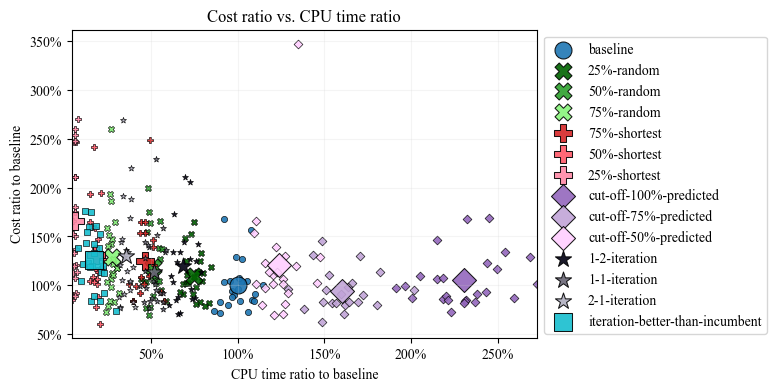

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

COLORS = {
    ("baseline", ""): "#1f77b4",
    ("ea", "25"): "#006300",
    ("ea", "50"): "#2ca02c",
    ("ea", "75"): "#89f57b",
    ("eb", "75"): "#d62728",
    ("eb", "50"): "#ff5968",
    ("eb", "25"): "#ff8aa7",
    ("ec", "100"): "#9467bd",
    ("ec", "75"): "#c1a4d8",
    ("ec", "50"): "#ffcfff",
    ("ia", "1+2"): "#010013", 
    ("ia", "1+1"): "#696676",
    ("ia", "2+1"): "#b1afc0",
    ("ib", ""): "#17becf",
}

LABELS = {
    ("baseline", ""): "baseline",
    ("ea", "25"): "25%-random",
    ("ea", "50"): "50%-random",
    ("ea", "75"): "75%-random",
    ("eb", "75"): "75%-shortest",
    ("eb", "50"): "50%-shortest",
    ("eb", "25"): "25%-shortest",
    ("ec", "100"): "cut-off-100%-predicted",
    ("ec", "75"): "cut-off-75%-predicted",
    ("ec", "50"): "cut-off-50%-predicted",
    ("ia", "1+2"): "1-2-iteration", 
    ("ia", "1+1"): "1-1-iteration",
    ("ia", "2+1"): "2-1-iteration",
    ("ib", ""): "iteration-better-than-incumbent",
}

MARKERS = {
    "baseline": "o",
    "ea": "X",
    "eb": "P",
    "ec": "D",
    "ia": "*",
    "ib": "s",
}

def plot_cost_vs_cpu_time_ratio(df, df_agg, plot_all=False):
    fig, ax = plt.subplots(figsize=(6, 4))

    baseline_cost = df_agg.at[("baseline", ""), "cost"]
    baseline_cpu_time = df_agg.at[("baseline", ""), "cpu_time"]

    for (policy, parg), row in df_agg.iterrows():
        if plot_all:
            _ = df.loc[(df["policy"] == policy) & (df["parg"] == parg)]
            plt.scatter(
                _["cpu_time"] / baseline_cpu_time,
                _["cost"] / baseline_cost,
                s=20,
                alpha=0.9,
                color=COLORS[(policy, parg)],
                marker=MARKERS[policy],
                linewidths=0.5,
                edgecolor="black",
            )
        plt.scatter(
            row["cpu_time_ratio_to_baseline"],
            row["cost_ratio_to_baseline"],
            s=150,
            alpha=0.9,
            color=COLORS[(policy, parg)],
            marker=MARKERS[policy],
            linewidths=0.75,
            edgecolor="black",
            label=LABELS[(policy, parg)],
        )

    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel("CPU time ratio to baseline")
    plt.ylabel("Cost ratio to baseline")
    if not plot_all:
        plt.xlim(0, 2.5)
        plt.ylim(0.9, 1.66)
    plt.title("Cost ratio vs. CPU time ratio")
    return fig, ax

# fig, ax = plot_cost_vs_cpu_time_ratio(df25, df25_agg, plot_all=True)
# fig, ax = plot_cost_vs_cpu_time_ratio(df100, df100_agg, plot_all=True)
fig, ax = plot_cost_vs_cpu_time_ratio(df250, df250_agg, plot_all=True)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

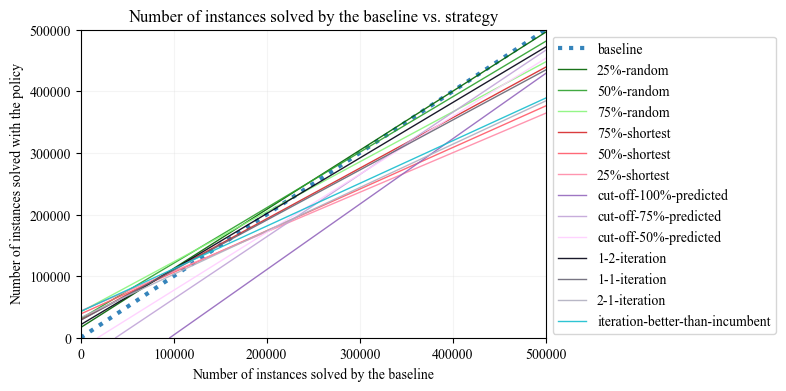

In [11]:
def plot_lines(df_agg, lim):
    fig, ax = plt.subplots(figsize=(6, 4))

    for (policy, parg), row in df_agg.iterrows():
        cost = row["cost"]
        cpu_time = row["cpu_time"]
        ax.axline(
            (0, row["beta"]),
            slope=row["alpha"],
            alpha=0.9,
            color=COLORS[(policy, parg)],
            lw=1 if policy != "baseline" else 3,
            ls="-" if policy != "baseline" else "dotted",
            label=LABELS[(policy, parg)],
        )

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel("Number of instances solved by the baseline")
    plt.ylabel("Number of instances solved with the policy")
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    plt.title("Number of instances solved by the baseline vs. strategy")
    return fig, ax

fig, ax = plot_lines(df25_agg, 500000)
# fig, ax = plot_lines(df100_agg, 1000000)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()